# WEATHER BASED ENERGY CONSUMPTION FORECASTING

## LIBRARIES

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input
from tensorflow.keras.layers import Dense, GRU, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tcn import TCN

## LOADING THE DATASETS AND SEEING FEATURE VISE PATTERNS

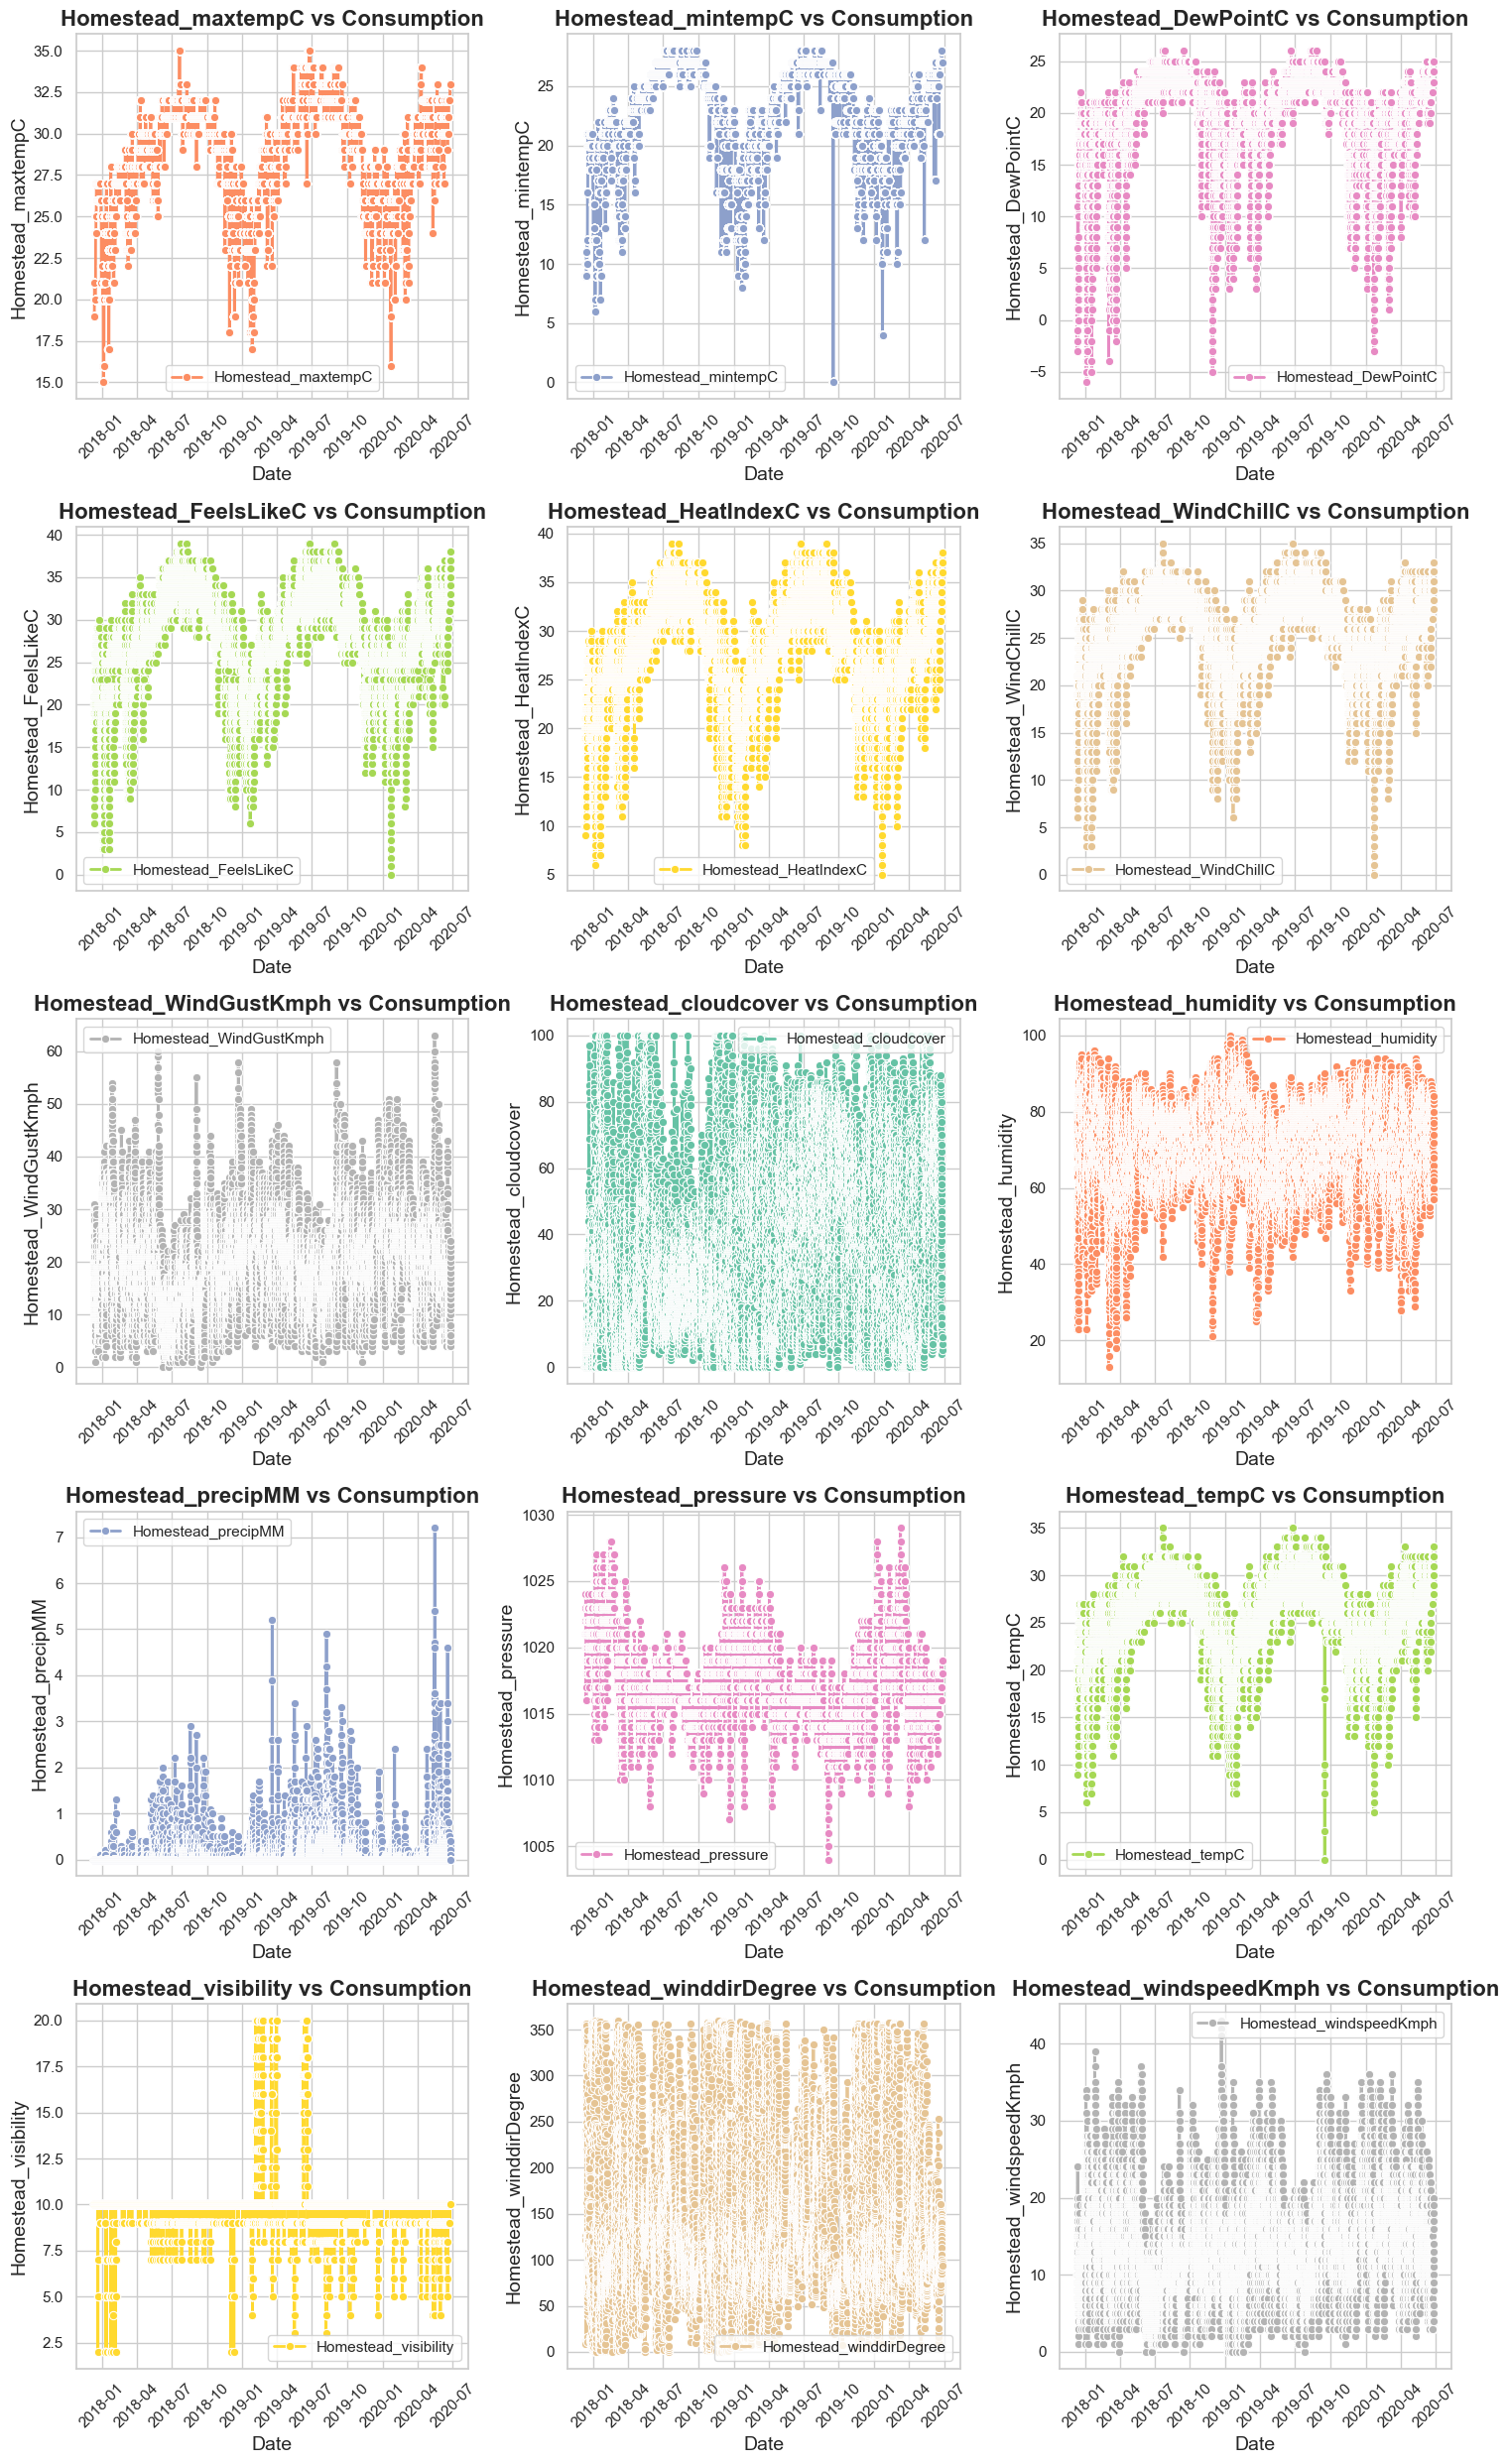

In [6]:
# Load the dataset
data = pd.read_csv('energyconsumption_dataset.csv')

# Parse the date column and set it as the index
data['Date'] = pd.to_datetime(data['Date'])
# Filter out unnamed columns and time-related columns (assuming 'Time' is one of the columns)
columns_to_plot = data.columns[~data.columns.str.contains('Unnamed|Time', case=False)]

# If 'Consumption' is part of columns_to_plot, remove it from the list
columns_to_plot = columns_to_plot[columns_to_plot != 'Consumption']

# Calculate the number of rows and columns for subplots based on the number of features
num_columns = len(columns_to_plot) - 1  # Remove the first graph
num_rows = (num_columns // 3) + (num_columns % 3 > 0)

# Set up the figure with a larger size and a better style
sns.set(style="whitegrid")  # Set Seaborn style
plt.figure(figsize=(15, 5 * num_rows))

# Loop through each feature starting from the second column and create a subplot
for i, col in enumerate(columns_to_plot[1:], 1):  # Start from the second column
    plt.subplot(num_rows, 3, i)  # Adjust the grid size dynamically
    
    # If plotting 'Consumption' vs 'Date', use a distinct color (dark red)
    if col == 'Consumption':
        sns.lineplot(x=data['Date'], y=data[col], label=col, marker="o", linewidth=2, markersize=6, color="darkred")
    else:
        # For other columns, use a different color from the Seaborn palette
        sns.lineplot(x=data['Date'], y=data[col], label=col, marker="o", linewidth=2, markersize=6, 
                     color=sns.color_palette("Set2")[i % len(sns.color_palette("Set2"))])

    # Set plot title and labels
    plt.title(f"{col} vs Consumption", fontsize=16, fontweight='bold')
    plt.xlabel("Date", fontsize=14)
    plt.ylabel(col, fontsize=14)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    
    # Add grid for better clarity
    plt.grid(True)
    
    # Show legend
    plt.legend()

plt.tight_layout()
plt.show()

## LOADING TRAIN AND TEST DATA

In [9]:
data.set_index('Date', inplace=True)

# Feature Engineering: Add time-related features (e.g., hour of the day, day of the week)
data['Hour'] = data.index.hour
data['DayOfWeek'] = data.index.dayofweek
data['Month'] = data.index.month
# Split the dataset into training and testing sets
train_data = data.loc[:'2020-01-01 00:00:00']
test_data = data.loc['2020-01-01 00:00:00':]
# Select features and target variable
X_train = train_data.drop(columns=['Consumption'])
y_train = train_data['Consumption']
X_test = test_data.drop(columns=['Consumption'])
y_test = test_data['Consumption']

# Standardize the features using the scaler fitted on the training data
scaler = StandardScaler()
# Fit the scaler on training data
X_train_scaled = scaler.fit_transform(X_train)
# Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test)

## TRAINING AN LSTM (Long Short-Term Memory) MODEL

In [12]:
##FOR LSTM
# Reshape for LSTM input (samples, timesteps, features)
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Define the LSTM model with Input layer
model = Sequential([
    Input(shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
    LSTM(32, activation='relu', return_sequences=False),  # Reduced LSTM units
    Dropout(0.4),  # Increased dropout rate to force more regularization
    Dense(16, activation='relu'),  # Smaller Dense layer
    Dropout(0.4),  # Another increased dropout layer
    Dense(1)  # Output layer for regression
])

# Compile the model
optimizer = Adam(learning_rate=0.001)  # Keep the same learning rate
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Implement EarlyStopping to avoid overfitting and halt training when the model is no longer improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping and validation split, keep epochs at 30
history = model.fit(X_train_reshaped, y_train, epochs=30, batch_size=32, validation_data=(X_test_reshaped, y_test),
                    callbacks=[early_stopping])


Epoch 1/30
562/562 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 3260.8586 - mae: 51.7497 - val_loss: 618.3986 - val_mae: 20.4601
Epoch 2/30
562/562 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 717.2316 - mae: 21.3702 - val_loss: 231.2079 - val_mae: 11.8311
Epoch 3/30
562/562 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 502.7849 - mae: 17.7185 - val_loss: 165.9067 - val_mae: 9.8584
Epoch 4/30
562/562 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 435.7751 - mae: 16.4452 - val_loss: 131.3241 - val_mae: 8.6942
Epoch 5/30
562/562 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 400.3618 - mae: 15.6880 - val_loss: 121.8503 - val_mae: 8.5396
Epoch 6/30
562/562 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 382.4652 - mae: 15.3674 - val_loss: 95.1602 - val_mae: 7.5346
Epoch 7/30
562/562 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 355.2458 - mae: 14.7092 - val_loss: 86.7309 - val_mae: 7.2594
Epoch 8/30
562/562 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 338.9423 - mae: 14.3319 - val_loss: 84.7851 - val_mae: 7.1211
Epoch 9/30
562/5

## TESTING LSTM MODEL AND CHECKING ACCURACY

In [15]:
# Predict on the test set
y_pred = model.predict(X_test_reshaped)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
accuracy = (1 - (mae / y_test.mean())) * 100  # Accuracy as percentage

# Print evaluation results
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"LSTM Accuracy: {accuracy:.2f}%")


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Mean Squared Error: 53.249577621440075
Mean Absolute Error: 5.7260601597957965
LSTM Accuracy: 91.06%


## VISUALIZING THE FEW TEST CASES OF THE TRAINED LSTM MODEL 

In [18]:
# Aggregate test data daily for plotting
test_results = pd.DataFrame({'Date': y_test.index, 'Actual': y_test.values, 'Predicted': y_pred.flatten()})
test_results['Date'] = test_results['Date'].dt.date  # Keep only the date part
daily_test_results = test_results.groupby('Date').mean().reset_index()

# Display first 5 and last 5 of actual vs predicted
first_5 = test_results.head(5)
last_5 = test_results.tail(5)
print("\nFirst 5 values in test data:")
print(first_5)
print("\nLast 5 values in test data:")
print(last_5)


First 5 values in test data:
         Date  Actual  Predicted
0  2020-01-01      80  73.871277
1  2020-01-01      75  68.265152
2  2020-01-01      66  62.214317
3  2020-01-01      58  57.619431
4  2020-01-01      52  53.436161

Last 5 values in test data:
            Date  Actual  Predicted
4214  2020-06-25      73  68.410622
4215  2020-06-25      82  72.098000
4216  2020-06-25      74  76.260506
4217  2020-06-25      99  81.428726
4218  2020-06-25     103  85.749489


## PLOTTING GRAPH FOR ACCURACY OF LSTM

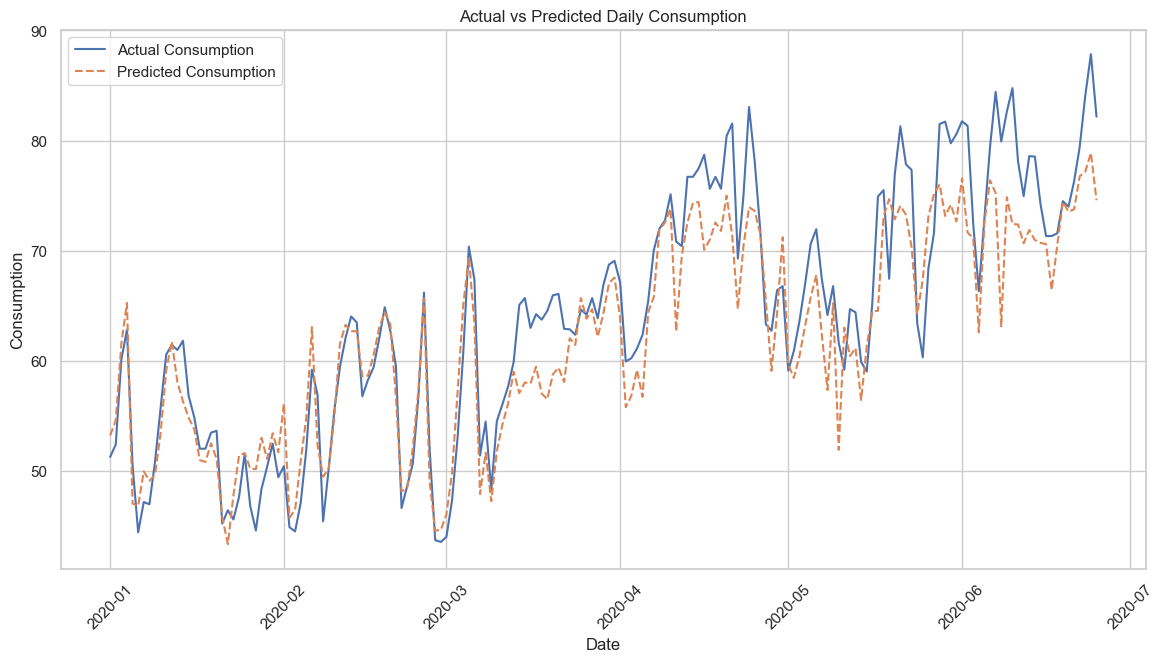

In [21]:
# Plot actual vs predicted values for the test set (daily)
plt.figure(figsize=(14, 7))
plt.plot(daily_test_results['Date'], daily_test_results['Actual'], label='Actual Consumption')
plt.plot(daily_test_results['Date'], daily_test_results['Predicted'], label='Predicted Consumption', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Consumption')
plt.title('Actual vs Predicted Daily Consumption')
plt.legend()
plt.xticks(rotation=45)
plt.show()

## TRAINING AN GRU (Gated Recurrent Units) MODEL

In [24]:
## GRU
# Reshape for GRU input (samples, timesteps, features)
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Define the GRU model using Input layer explicitly for the first layer
model = Sequential([
    Input(shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),  # Explicit Input layer
    GRU(32, activation='relu', return_sequences=False),  # Reduced GRU units to reduce model capacity
    Dropout(0.4),  # Increased dropout rate to force more regularization
    Dense(16, activation='relu'),  # Smaller Dense layer to limit model's expressive power
    Dropout(0.4),  # Another Dropout layer to increase regularization
    Dense(1)  # Output layer for regression
])

# Compile the model
optimizer = Adam(learning_rate=0.001)  # Keep the same learning rate
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Implement EarlyStopping to avoid overfitting and halt training when the model is no longer improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping and validation split, keep epochs at 50
history = model.fit(X_train_reshaped, y_train, epochs=30, batch_size=64, validation_data=(X_test_reshaped, y_test),  # Increased batch size
                    callbacks=[early_stopping])

Epoch 1/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 4065.7139 - mae: 60.5721 - val_loss: 875.7621 - val_mae: 24.6940
Epoch 2/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 976.8397 - mae: 25.6650 - val_loss: 328.8629 - val_mae: 14.6137
Epoch 3/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 608.9539 - mae: 19.6201 - val_loss: 214.4746 - val_mae: 11.7099
Epoch 4/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 531.2819 - mae: 18.2702 - val_loss: 177.5837 - val_mae: 10.6225
Epoch 5/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 475.3262 - mae: 17.1754 - val_loss: 157.2475 - val_mae: 9.9657
Epoch 6/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 452.0848 - mae: 16.8799 - val_loss: 151.5280 - val_mae: 9.7520
Epoch 7/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 441.9477 - mae: 16.5286 - val_loss: 138.8122 - val_mae: 9.3521
Epoch 8/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 432.2399 - mae: 16.2945 - val_loss: 135.6714 - val_mae: 9.1459
Epoch 9/30


## TESTING GRU MODEL AND CHECKING ACCURACY

In [27]:
# Predict on the test set
y_pred = model.predict(X_test_reshaped)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
accuracy = (1 - (mae / y_test.mean())) * 100  # Accuracy as percentage

# Print evaluation results
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"GRU Accuracy: {accuracy:.2f}%")

132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Mean Squared Error: 53.966530827659696
Mean Absolute Error: 5.727244661724039
GRU Accuracy: 91.06%


## VISUALIZING THE FEW TEST CASES OF THE TRAINED GRU MODEL

In [30]:
# Aggregate test data daily for plotting
test_results = pd.DataFrame({'Date': y_test.index, 'Actual': y_test.values, 'Predicted': y_pred.flatten()})
test_results['Date'] = test_results['Date'].dt.date  # Keep only the date part
daily_test_results = test_results.groupby('Date').mean().reset_index()

# Display first 5 and last 5 of actual vs predicted
first_5 = test_results.head(5)
last_5 = test_results.tail(5)
print("\nFirst 5 values in test data:")
print(first_5)
print("\nLast 5 values in test data:")
print(last_5)


First 5 values in test data:
         Date  Actual  Predicted
0  2020-01-01      80  74.461945
1  2020-01-01      75  68.795341
2  2020-01-01      66  62.431335
3  2020-01-01      58  57.456249
4  2020-01-01      52  52.362484

Last 5 values in test data:
            Date  Actual  Predicted
4214  2020-06-25      73  69.081619
4215  2020-06-25      82  72.366348
4216  2020-06-25      74  75.527206
4217  2020-06-25      99  80.711090
4218  2020-06-25     103  84.904587


## PLOTTING GRAPH FOR ACCURACY OF GRU MODEL

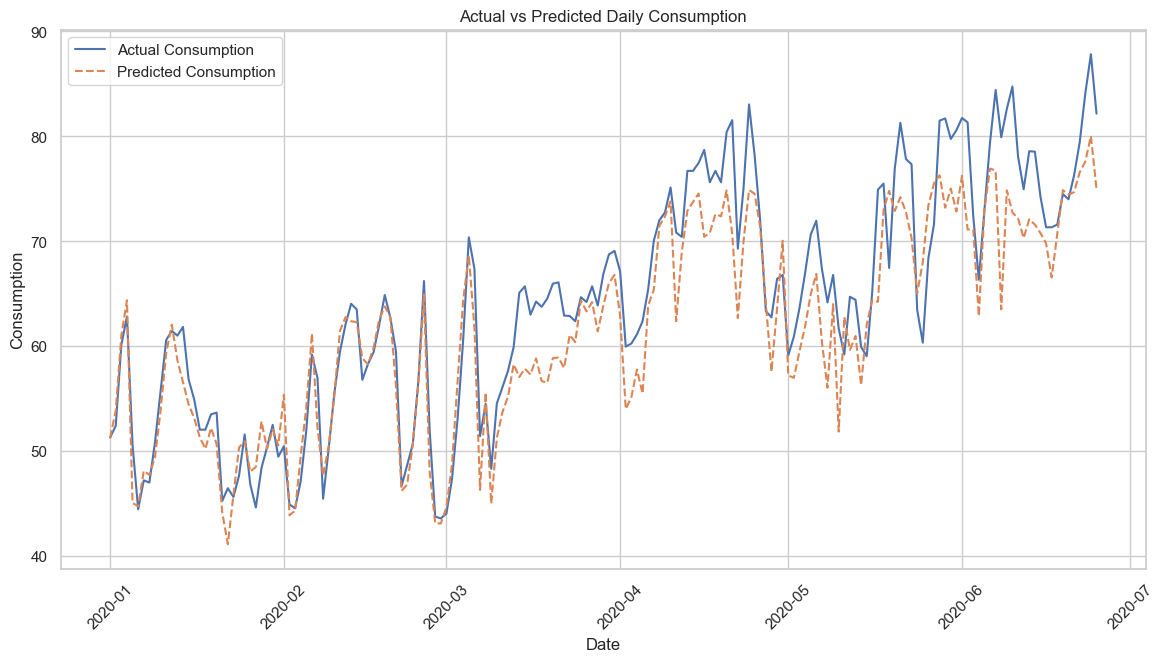

In [33]:
# Plot actual vs predicted values for the test set (daily)
plt.figure(figsize=(14, 7))
plt.plot(daily_test_results['Date'], daily_test_results['Actual'], label='Actual Consumption')
plt.plot(daily_test_results['Date'], daily_test_results['Predicted'], label='Predicted Consumption', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Consumption')
plt.title('Actual vs Predicted Daily Consumption')
plt.legend()
plt.xticks(rotation=45)
plt.show()

## TRAINING AN TCN (Temporal Convolutional Network) MODEL

In [36]:
## TCN
# Create a separate scaler for the Consumption values
consumption_scaler = StandardScaler()

# Fit the scaler on the Consumption column of the training data
y_train_scaled = consumption_scaler.fit_transform(y_train.values.reshape(-1, 1))

# Scale the Consumption column of the test data
y_test_scaled = consumption_scaler.transform(y_test.values.reshape(-1, 1))

# Reshape for TCN input (samples, timesteps, features)
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Define the TCN model with Input layer
model = Sequential([
    Input(shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
    TCN(nb_filters=64, kernel_size=3, dropout_rate=0.2, return_sequences=False),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Implement EarlyStopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping and validation split
history = model.fit(X_train_reshaped, y_train_scaled, epochs=30, batch_size=32, validation_data=(X_test_reshaped, y_test_scaled),
                    callbacks=[early_stopping])


Epoch 1/30
562/562 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 2.5378 - mae: 1.0226 - val_loss: 0.5349 - val_mae: 0.5916
Epoch 2/30
562/562 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.3660 - mae: 0.4785 - val_loss: 0.3222 - val_mae: 0.4519
Epoch 3/30
562/562 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.2533 - mae: 0.3910 - val_loss: 0.2157 - val_mae: 0.3615
Epoch 4/30
562/562 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.1956 - mae: 0.3417 - val_loss: 0.1776 - val_mae: 0.3297
Epoch 5/30
562/562 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.1613 - mae: 0.3091 - val_loss: 0.2038 - val_mae: 0.3566
Epoch 6/30
562/562 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.1431 - mae: 0.2903 - val_loss: 0.1820 - val_mae: 0.3371
Epoch 7/30
562/562 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.1372 - mae: 0.2810 - val_loss: 0.1709 - val_mae: 0.3239
Epoch 8/30
562/562 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.1282 - mae: 0.2723 - val_loss: 0.1882 - val_mae: 0.3453
Epoch 9/30
562/562 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step -

## TESTING TCN MODEL AND CHECKING ACCURACY

In [39]:
# Predict on the test set and inverse transform the predictions
y_pred_scaled = model.predict(X_test_reshaped)
y_pred = consumption_scaler.inverse_transform(y_pred_scaled)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
accuracy = (1 - (mae / y_test.mean())) * 100

# Print evaluation results
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Accuracy: {accuracy:.2f}%")

132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Mean Squared Error: 31.659292560089973
Mean Absolute Error: 4.253537842831246
Accuracy: 93.36%


## VISUALIZING THE FEW TEST CASES OF THE TRAINED TCN MODEL

In [42]:
# Aggregate test data daily for plotting
test_results = pd.DataFrame({'Date': y_test.index, 'Actual': y_test.values, 'Predicted': y_pred.flatten()})
test_results['Date'] = test_results['Date'].dt.date  # Keep only the date part
daily_test_results = test_results.groupby('Date').mean().reset_index()

# Display first 5 and last 5 of actual vs predicted
first_5 = test_results.head(5)
last_5 = test_results.tail(5)
print("\nFirst 5 values in test data:")
print(first_5)
print("\nLast 5 values in test data:")
print(last_5)


First 5 values in test data:
         Date  Actual  Predicted
0  2020-01-01      80  77.788338
1  2020-01-01      75  71.791786
2  2020-01-01      66  63.664268
3  2020-01-01      58  55.687622
4  2020-01-01      52  48.350201

Last 5 values in test data:
            Date  Actual  Predicted
4214  2020-06-25      73  71.767494
4215  2020-06-25      82  78.287933
4216  2020-06-25      74  85.444351
4217  2020-06-25      99  92.394417
4218  2020-06-25     103  98.789436


## PLOTTING GRAPH FOR ACCURACY OF THE TCN MODEL

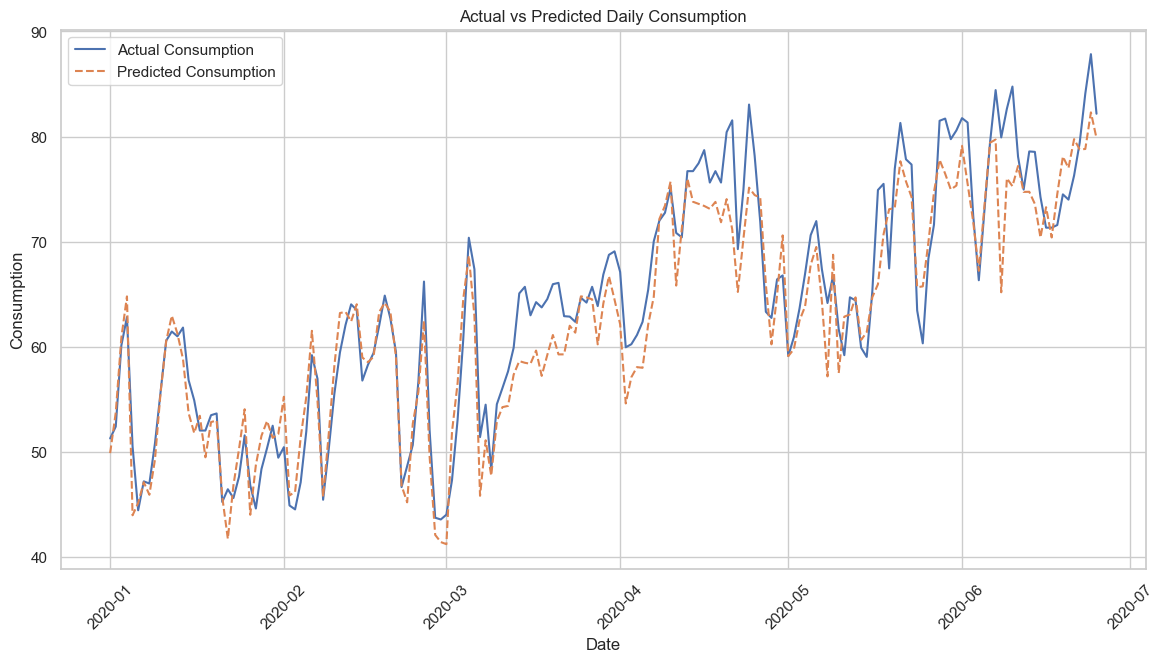

In [45]:
# Plot actual vs predicted values for the test set (daily)
plt.figure(figsize=(14, 7))
plt.plot(daily_test_results['Date'], daily_test_results['Actual'], label='Actual Consumption')
plt.plot(daily_test_results['Date'], daily_test_results['Predicted'], label='Predicted Consumption', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Consumption')
plt.title('Actual vs Predicted Daily Consumption')
plt.legend()
plt.xticks(rotation=45)
plt.show()

## FUTURE FORECASTING BASED ON MOST ACCURATE MODEL

## TRAINING MODEL FOR FORECASTING

In [49]:
## BEST ACCURACY IS FOR TCN
## USING TCN TO PREDICT CONSUMPTION FOR THE NEXT 30 DAYS
# Forecasting the next 30 days of consumption
num_days_to_predict = 30
future_predictions = []
input_data = X_test_scaled[-1].reshape(1, 1, -1)

for _ in range(num_days_to_predict):
    next_pred = model.predict(input_data)
    future_predictions.append(next_pred[0, 0])
    next_pred_expanded = np.expand_dims(next_pred, axis=-1)
    input_data = np.append(input_data[:, :, 1:], next_pred_expanded, axis=2)

# Define the last date from the test results
last_date = test_results['Date'].iloc[-1]

# Inverse transform and smooth the predictions using a moving average
future_predictions = consumption_scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))
smoothed_future_predictions = pd.Series(future_predictions.flatten()).rolling(window=3, min_periods=1).mean().values

# Create a forecast DataFrame with values
future_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=num_days_to_predict)
forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Forecasted Consumption': smoothed_future_predictions
})

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

## Forecasted CONSUMPTION FOR NEXT 30 DAYS

In [52]:
# Display the forecasted consumption for the next 30 days
print("\nForecast for the next 30 days:")
print(forecast_df)


Forecast for the next 30 days:
         Date  Forecasted Consumption
0  2020-06-26               98.789436
1  2020-06-27               81.701511
2  2020-06-28               75.060327
3  2020-06-29               74.519215
4  2020-06-30               73.996380
5  2020-07-01               71.561021
6  2020-07-02               70.254787
7  2020-07-03               65.325328
8  2020-07-04               63.370822
9  2020-07-05               60.428772
10 2020-07-06               65.485466
11 2020-07-07               68.723073
12 2020-07-08               71.282613
13 2020-07-09               67.396408
14 2020-07-10               67.479239
15 2020-07-11               69.133801
16 2020-07-12               71.372869
17 2020-07-13               72.545219
18 2020-07-14               76.477150
19 2020-07-15               73.394385
20 2020-07-16               72.591822
21 2020-07-17               71.299431
22 2020-07-18               73.832561
23 2020-07-19               72.976882
24 2020-07-20     

## PLOT FOR FUTURE PREDICTION

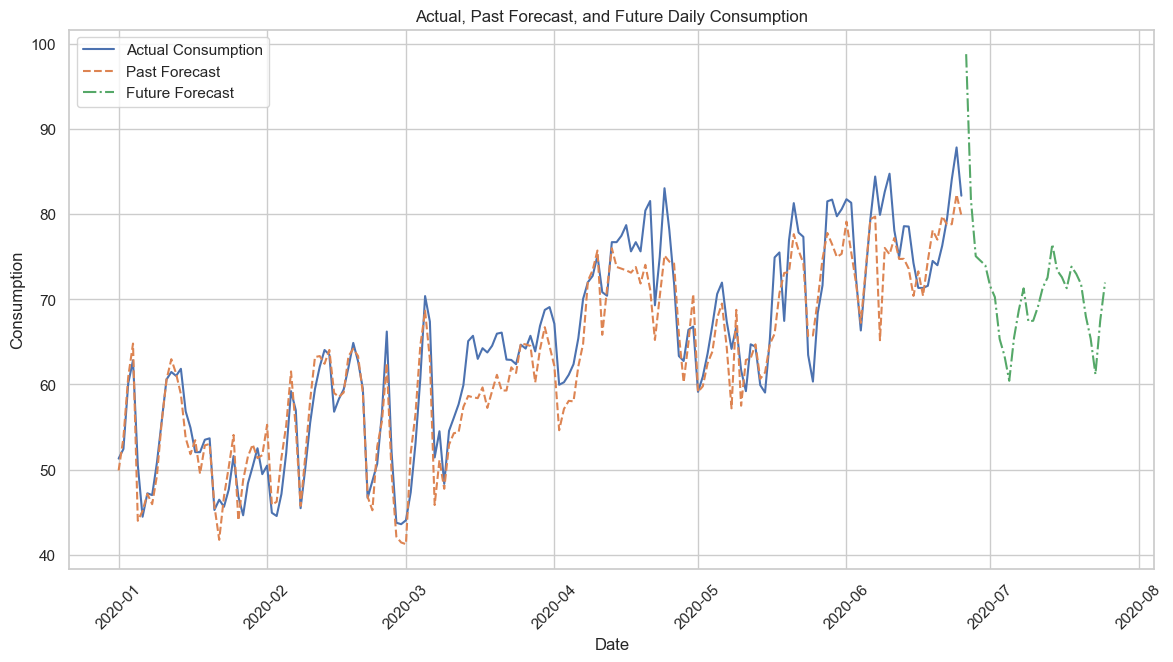

In [55]:
# Plot the future forecasts along with actual and past forecasted values
plt.figure(figsize=(14, 7))
plt.plot(daily_test_results['Date'], daily_test_results['Actual'], label='Actual Consumption')
plt.plot(daily_test_results['Date'], daily_test_results['Predicted'], label='Past Forecast', linestyle='--')
plt.plot(forecast_df['Date'], forecast_df['Forecasted Consumption'], label='Future Forecast', linestyle='-.')
plt.xlabel('Date')
plt.ylabel('Consumption')
plt.title('Actual, Past Forecast, and Future Daily Consumption')
plt.legend()
plt.xticks(rotation=45)
plt.show()